# Estudio: Métodos Tabulares

- Tomás Díaz Díaz
- Jose Antonio Sánchez Fernández

## Introducción

En este notebook se va a realizar el análisis y el estudio comparativo de los distintos métodos tabulares, que en nuestro caso son los siguientes: 
- Monte Carlo (on-policy y off-policy)
- Diferencias temporales (SARSA, QLearning) 
  
Para ello vamos a hacer uso del entorno de Gymnasium, que nos permite ensayar con distintos algoritmos de aprendizaje en diferentes escenarios, en nuestro caso hemos escogido el mapa llamado "Frozen Lake".


## Importaciones y configuración

A continuación vamos a importar las librerías necesarias para llevar a cabo el análisis y además vamos a establecer una serie de semillas para que las ejecuciones siempre tengan los mismos resultados.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import sys
import os
import gc
import torch

from tqdm import tqdm
sys.path.append('src/')
from AgentMonteCarloOnPolicy import AgentMonteCarloOnPolicy
from AgentMonteCarloOffPolicy import AgentMonteCarloOffPolicy
from AgentSARSA import AgentSARSA

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

gc.collect()
torch.cuda.empty_cache()

# Fijamos la semilla para reproducibilidad
seed = 42
np.random.seed(seed) 
np.random.default_rng(seed)
torch.manual_seed(seed)

# Fijamos la semilla en Gymnasium
def make_env(env_name, map_name):
    env = gym.make(env_name, map_name=map_name, is_slippery=False, render_mode='ansi')
    env.reset(seed=seed)
    return env

Usando dispositivo: cpu


Definimos las funciones para las distintas gráficas.

In [64]:
def plot(list_stats):
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

# Define la función para mostrar el tamaño de los episodios
# Pon aquí tu código.

def plot_episode_lengths(episode_lengths):
    """Grafica la longitud de los episodios a lo largo del tiempo."""
    plt.figure(figsize=(30, 10))
    plt.plot(range(len(episode_lengths)), episode_lengths, label="Longitud del episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Longitud")
    plt.title("Evolución de la Longitud de los Episodios")
    plt.grid(True)
    plt.legend()
    plt.show()

## Preparación del entorno

In [65]:
# En nuestro caso, el entorno es el de FrozenLake-v1
env_name = "FrozenLake-v1"

# Vamos a utilizar 5000 episodios para el entrenamiento
n_episodes = 5000
mc_on_policy_env = make_env(env_name, "4x4")
mc_on_policy_env = gym.wrappers.RecordEpisodeStatistics(mc_on_policy_env, buffer_length=n_episodes)
mc_off_policy_env = make_env(env_name, "4x4")
mc_off_policy_env = gym.wrappers.RecordEpisodeStatistics(mc_off_policy_env, buffer_length=n_episodes)
sarsa_env = make_env(env_name, "4x4")
sarsa_env = gym.wrappers.RecordEpisodeStatistics(sarsa_env, buffer_length=n_episodes)

## Creación de agentes

A continuación vamos a dar una breve explicación de cada uno de los algoritmos utilizados en este estudio:

- Monte Carlo es una técnica de aprendizaje por refuerzo basada en la experiencia completa del episodio. En lugar de actualizar paso a paso, espera a que el episodio termine para calcular el retorno total desde cada estado-acción y usar ese valor para mejorar la estimación. Tenemos dos variantes:
  - On-Policy: aprende la política que sigue el agente (por ejemplo, ε-greedy). Utiliza exploración y actualiza Q en función de las acciones realmente tomadas.
  - Off-Policy: aprende sobre una política diferente a la que se sigue, utilizando técnicas como importancia relativa (importance sampling) para corregir el sesgo entre la política de comportamiento y la política objetivo.
- Diferencias Temporales: a diferencia de Monte Carlo, estos métodos actualizan los valores después de cada paso, basándose en una mezcla de experiencia real y estimaciones actuales. Tenemos también dos variantes:
  - SARSA: es un algoritmo on-policy, lo que significa que actualiza su política utilizando las acciones que realmente se toman, con exploración incluida (como ε-greedy).
  - Q-Learning: es un algoritmo off-policy. aprende el valor óptimo de las acciones asumiendo que siempre se tomará la mejor acción posible, sin importar la acción que el agente realmente ejecutó.

Ahora vamos a crear los cuatro agentes.

In [66]:
mc_on_policy_agent = AgentMonteCarloOnPolicy(mc_on_policy_env, num_episodes=5000, seed=seed)
mc_off_policy_agent = AgentMonteCarloOffPolicy(mc_off_policy_env, num_episodes=5000, seed=seed)
sarsa_agent = AgentSARSA(sarsa_env, num_episodes=5000, seed=seed)

## Entrenamiento
En esta sección vamos a entrenar a los agentes, imprimiendo la política óptima.

In [67]:
mc_on_policy_agent.train()
print("\nOptimal policy:")
policy = mc_on_policy_agent.get_optimal_policy()
action_names = ['←', '↓', '→', '↑']
for s in range(mc_on_policy_env.observation_space.n):
    print(f"State {s}: {action_names[policy[s]]}")

mc_on_policy_agent.test()

Training: 100%|██████████| 5000/5000 [00:03<00:00, 1451.38it/s]


Success rate: 2194/5000 (43.88%)

Optimal policy:
State 0: ↓
State 1: →
State 2: ↓
State 3: ←
State 4: ↓
State 5: ←
State 6: ↓
State 7: ←
State 8: →
State 9: ↓
State 10: ↓
State 11: ←
State 12: ←
State 13: →
State 14: →
State 15: ←
Test success rate: 100/100 (100.00%)


In [68]:
mc_off_policy_agent.train()
print("\nOptimal policy:")
policy = mc_off_policy_agent.get_optimal_policy()
action_names = ['←', '↓', '→', '↑']
for s in range(mc_off_policy_env.observation_space.n):
    print(f"State {s}: {action_names[policy[s]]}")

mc_off_policy_agent.test()

Training (Off-Policy): 100%|██████████| 5000/5000 [00:06<00:00, 721.81it/s] 


Optimal policy:
State 0: ↓
State 1: →
State 2: ↓
State 3: ←
State 4: ↓
State 5: ←
State 6: ↓
State 7: ←
State 8: →
State 9: →
State 10: ↓
State 11: ←
State 12: ←
State 13: →
State 14: →
State 15: ←
Test success rate: 100/100 (100.00%)


In [69]:
sarsa_agent.train()
print("\nOptimal policy:")
policy = sarsa_agent.get_optimal_policy()
action_names = ['←', '↓', '→', '↑']
for s in range(sarsa_env.observation_space.n):
    print(f"State {s}: {action_names[policy[s]]}")

sarsa_agent.test()

Training: 100%|██████████| 5000/5000 [00:00<00:00, 5668.95it/s]



Success rate: 2136/5000 (42.72%)

Optimal policy:
State 0: ↓
State 1: →
State 2: ↓
State 3: ←
State 4: ↓
State 5: ←
State 6: ↓
State 7: ←
State 8: →
State 9: →
State 10: ↓
State 11: ←
State 12: ←
State 13: →
State 14: →
State 15: ←
Test success rate: 100/100 (100.00%)


## Evaluación

A continuación vamos a definir las funciones para mostrar los gráficos de las recompensas por episodio y la duración de cada uno.

In [97]:
def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

def plot_episode_rewards(envs, rolling_length = 500):
    plt.figure(figsize=(30, 10))
    for name, env in envs:
        reward_moving_average = get_moving_avgs(
            env.return_queue,
            rolling_length,
            "valid"
        )
        plt.plot(range(len(reward_moving_average)), reward_moving_average, label=name)
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.title("Evolución de la recompensa de los Episodios")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_episode_lengths(envs, rolling_length = 500):
    plt.figure(figsize=(30, 10))
    for name, env in envs:
        length_moving_average = get_moving_avgs(
            env.length_queue,
            rolling_length,
            "valid"
        )
        plt.plot(range(len(length_moving_average)), length_moving_average, label=name)
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.title("Evolución de la recompensa de los Episodios")
    plt.grid(True)
    plt.legend()
    plt.show()

Mostramos las recompensas de los episodios.

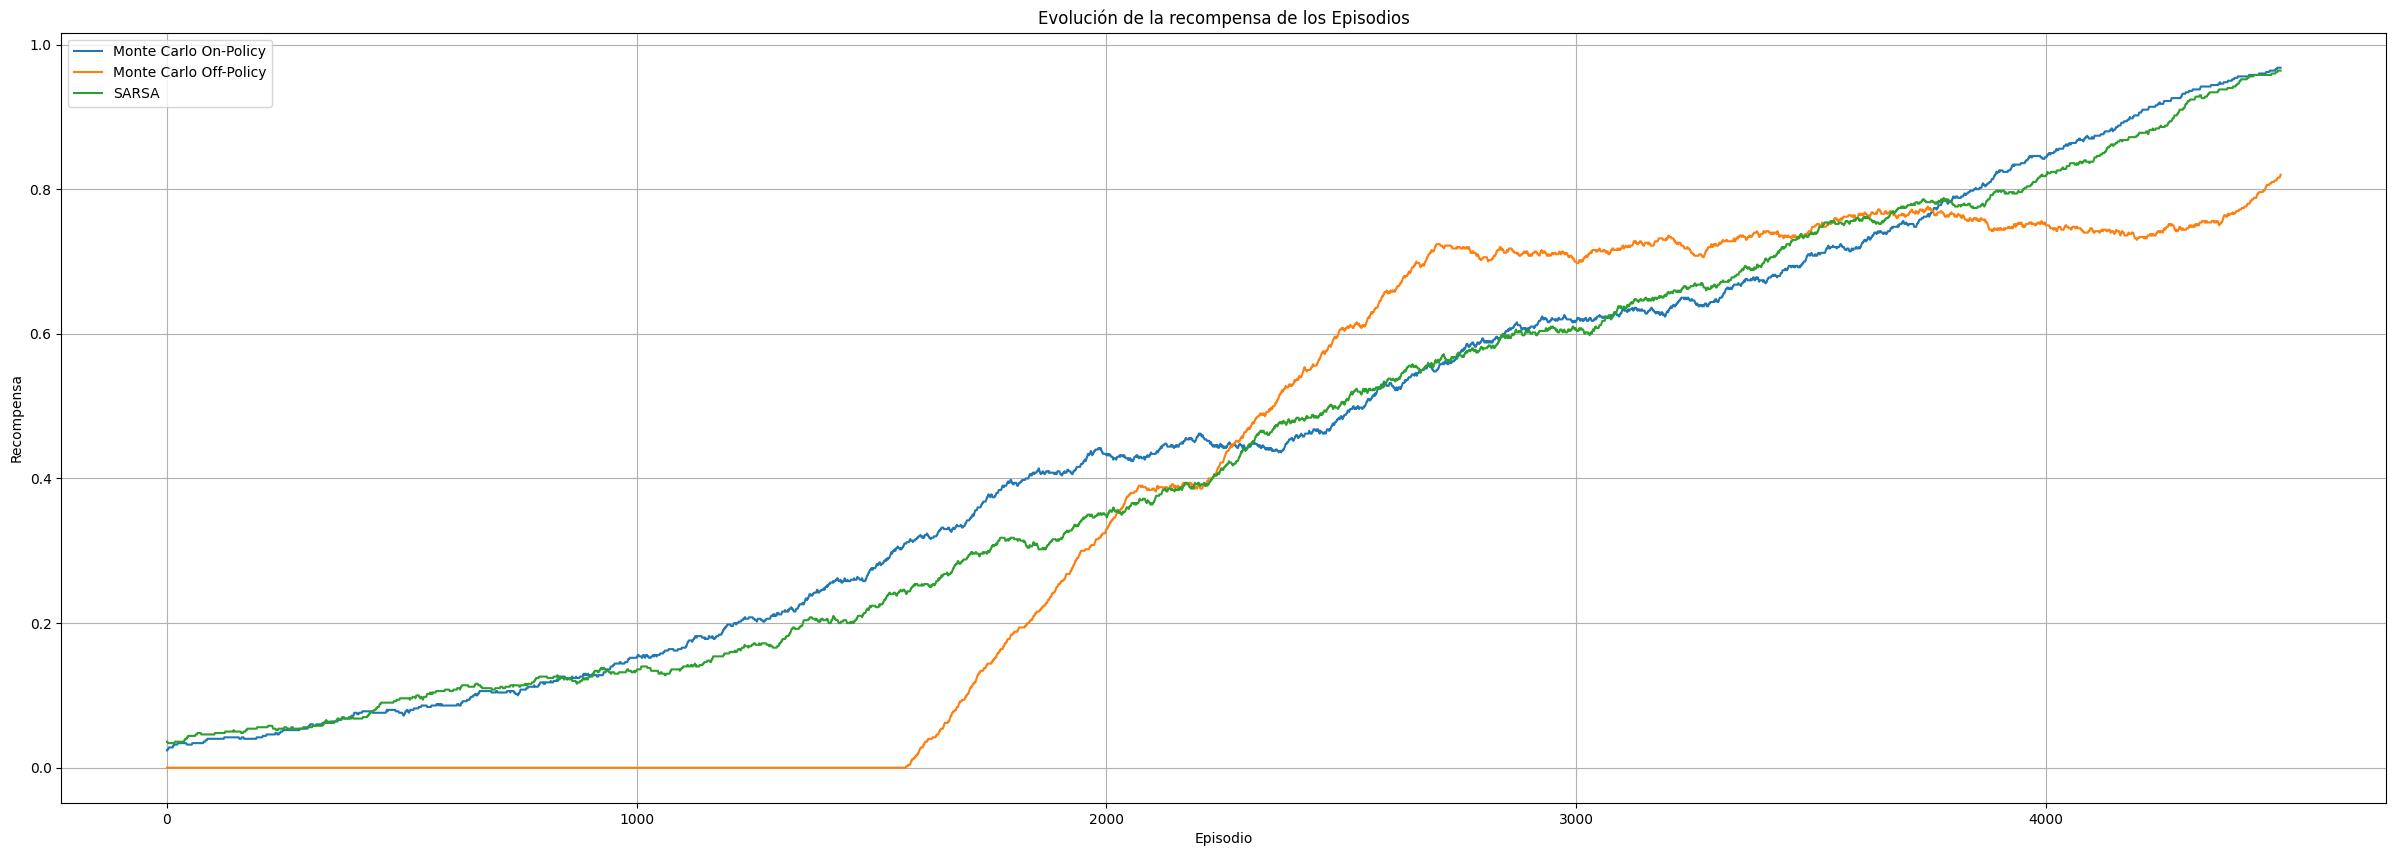

In [96]:
plot_episode_rewards([
    ("Monte Carlo On-Policy", mc_on_policy_env),
    ("Monte Carlo Off-Policy", mc_off_policy_env),
    ("SARSA", sarsa_env)
], rolling_length=500)

Mostramos la duración de los episodios

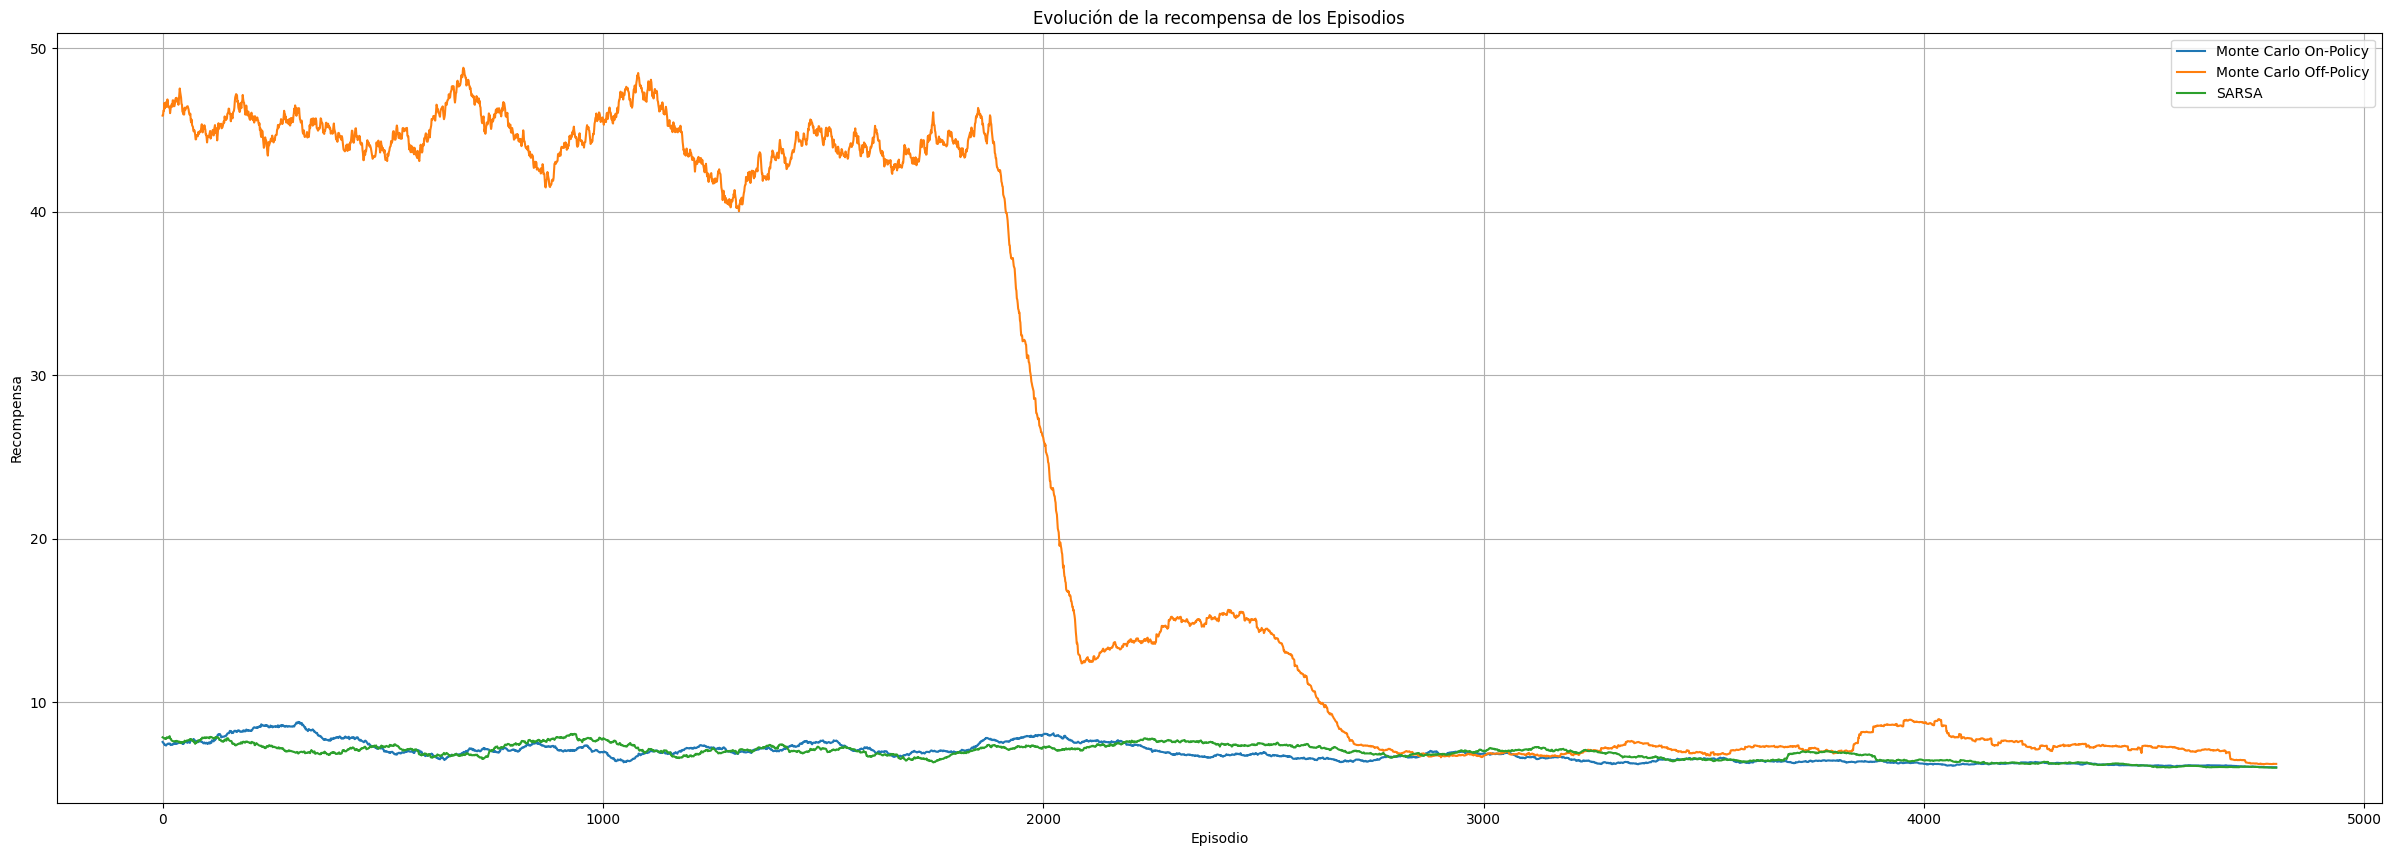

In [99]:
plot_episode_lengths([
    ("Monte Carlo On-Policy", mc_on_policy_env),
    ("Monte Carlo Off-Policy", mc_off_policy_env),
    ("SARSA", sarsa_env)
], rolling_length=200)